# Time-Series with ARIMA

### Goal

Evaluate the performance of various models and identify the best approach for making predictions.

Download the [dataset here](https://www.kaggle.com/datasets/fema/federal-disasters/data).

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import pmdarima as pm
from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore")

## Load Data

In [2]:
df = pd.read_csv("../data/database.csv")
df.head()

,Declaration Number,Declaration Type,Declaration Date,State,County,Disaster Type,Disaster Title,Start Date,End Date,Close Date,Individual Assistance Program,Individuals & Households Program,Public Assistance Program,Hazard Mitigation Program
0,DR-1,Disaster,05/02/1953,GA,NaN,Tornado,Tornado,05/02/1953,05/02/1953,06/01/1954,Yes,No,Yes,Yes
1,DR-2,Disaster,05/15/1953,TX,NaN,Tornado,Tornado and Heavy Rainfall,05/15/1953,05/15/1953,01/01/1958,Yes,No,Yes,Yes
2,DR-3,Disaster,05/29/1953,LA,NaN,Flood,Flood,05/29/1953,05/29/1953,02/01/1960,Yes,No,Yes,Yes
3,DR-4,Disaster,06/02/1953,MI,NaN,Tornado,Tornado,06/02/1953,06/02/1953,02/01/1956,Yes,No,Yes,Yes
4,DR-5,Disaster,06/06/1953,MT,NaN,Flood,Floods,06/06/1953,06/06/1953,12/01/1955,Yes,No,Yes,Yes


In [3]:
df.shape

(46185, 14)

In [4]:
diff_date = df["Declaration Date"] != df["Start Date"]
diff_date.value_counts()

True     36458
False     9727
Name: count, dtype: int64

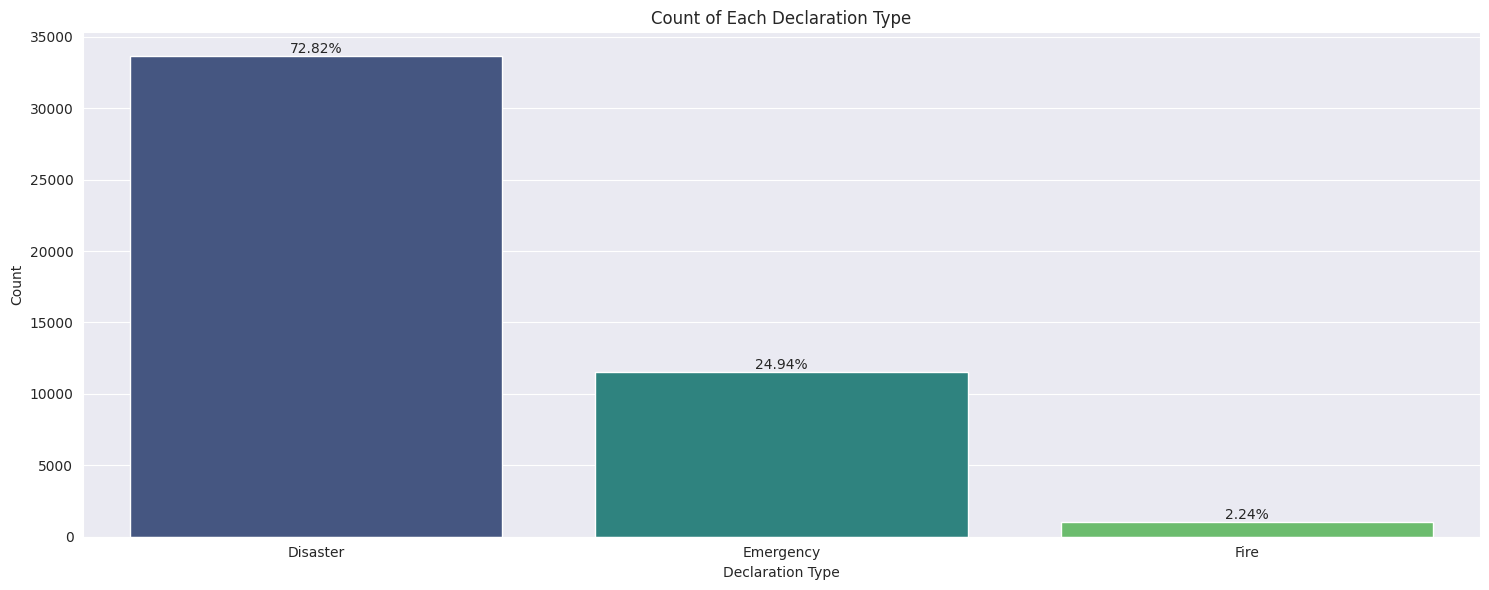

In [5]:
declaration_type_counts = df['Declaration Type'].value_counts()

total_count = declaration_type_counts.sum()
percentages = (declaration_type_counts / total_count) * 100

plt.figure(figsize=(15, 6))
ax = sns.barplot(x=declaration_type_counts.index, y=declaration_type_counts.values, hue=declaration_type_counts.index, palette='viridis')
plt.xlabel('Declaration Type')
plt.ylabel('Count')
plt.title('Count of Each Declaration Type')

for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{percentage:.2f}%', ha='center', va='bottom')

plt.tight_layout();


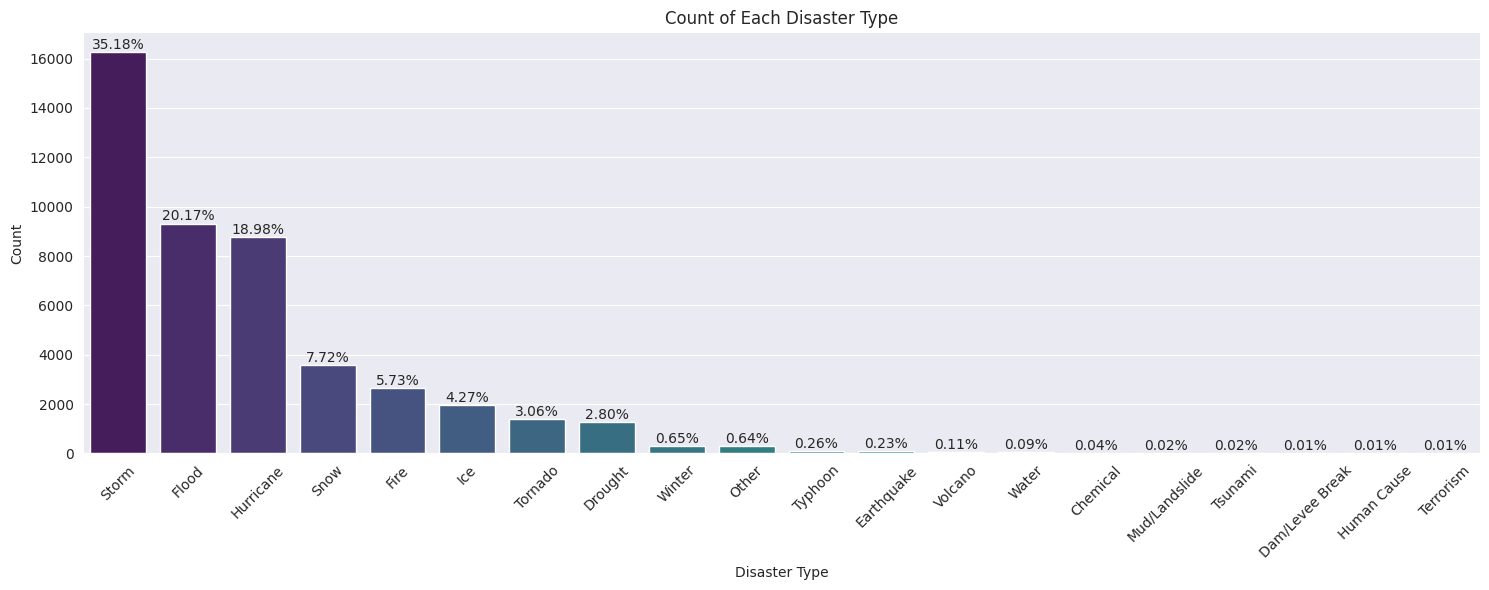

In [6]:
disaster_type_counts = df['Disaster Type'].value_counts()

total_count = disaster_type_counts.sum()
percentages = (disaster_type_counts / total_count) * 100

plt.figure(figsize=(15, 6))
ax = sns.barplot(x=disaster_type_counts.index, y=disaster_type_counts.values, hue=disaster_type_counts.index, palette='viridis')
plt.xlabel('Disaster Type')
plt.ylabel('Count')
plt.title('Count of Each Disaster Type')

for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(p.get_x() + p.get_width() / 2., height + 1, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xticks(rotation=45)  
plt.tight_layout();

In [7]:
df['Declaration Date'] = pd.to_datetime(df['Declaration Date'])
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['End Date'] = pd.to_datetime(df['End Date'])

df['Timestamp'] = df['Declaration Date']

# Aggregate the data to count the total disasters per date
count_df = df.groupby('Timestamp').agg(
    Total_Disasters=('Declaration Type', 'count')
).reset_index()

count_df.set_index('Timestamp', inplace=True)

# Resample the time series to daily frequency and drop missing days
daily_ts_data = count_df['Total_Disasters'].asfreq('D').dropna()
daily_ts_df = daily_ts_data.to_frame()

In [8]:
daily_ts_df.head()

,Total_Disasters
Timestamp,
1953-05-02,1.0
1953-05-15,1.0
1953-05-29,1.0
1953-06-02,1.0
1953-06-06,1.0


In [9]:
daily_ts_df.isna().sum()

Total_Disasters    0
dtype: int64

In [10]:
daily_ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2507 entries, 1953-05-02 to 2017-02-14
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Total_Disasters  2507 non-null   float64
dtypes: float64(1)
memory usage: 39.2 KB


In [11]:
daily_ts_df.describe()

,Total_Disasters
count,2507.000000
mean,18.422417
std,39.371001
min,1.000000
25%,2.000000
50%,6.000000
75%,20.000000
max,777.000000


Skewness: 8.49
Kurtosis: 116.59


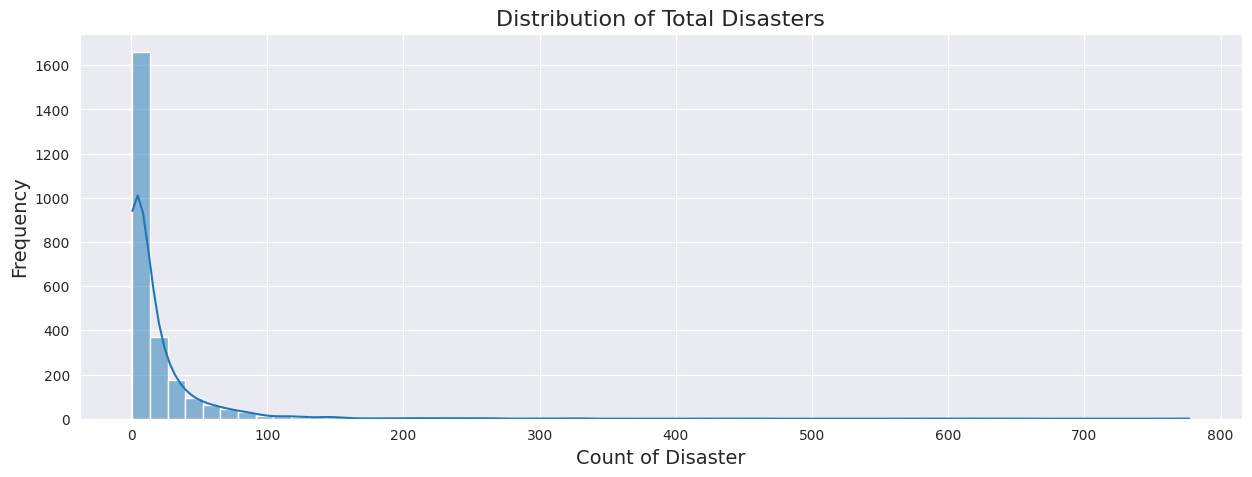

In [12]:
skewness = daily_ts_df['Total_Disasters'].skew()
kurtosis_value = daily_ts_df['Total_Disasters'].kurt()

print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis_value:.2f}")

plt.figure(figsize=(15, 5))
sns.histplot(daily_ts_df['Total_Disasters'], kde=True, bins=60)

plt.title('Distribution of Total Disasters', fontsize=16)
plt.xlabel('Count of Disaster', fontsize=14)
plt.ylabel('Frequency', fontsize=14)


plt.grid(True);

- The skewness of `Total_Disasters` is **8.49**, and the kurtosis is **116.59**, indicating that the distribution is **heavily right-skewed.**
- Additionally, the variable is **not normally distributed**.

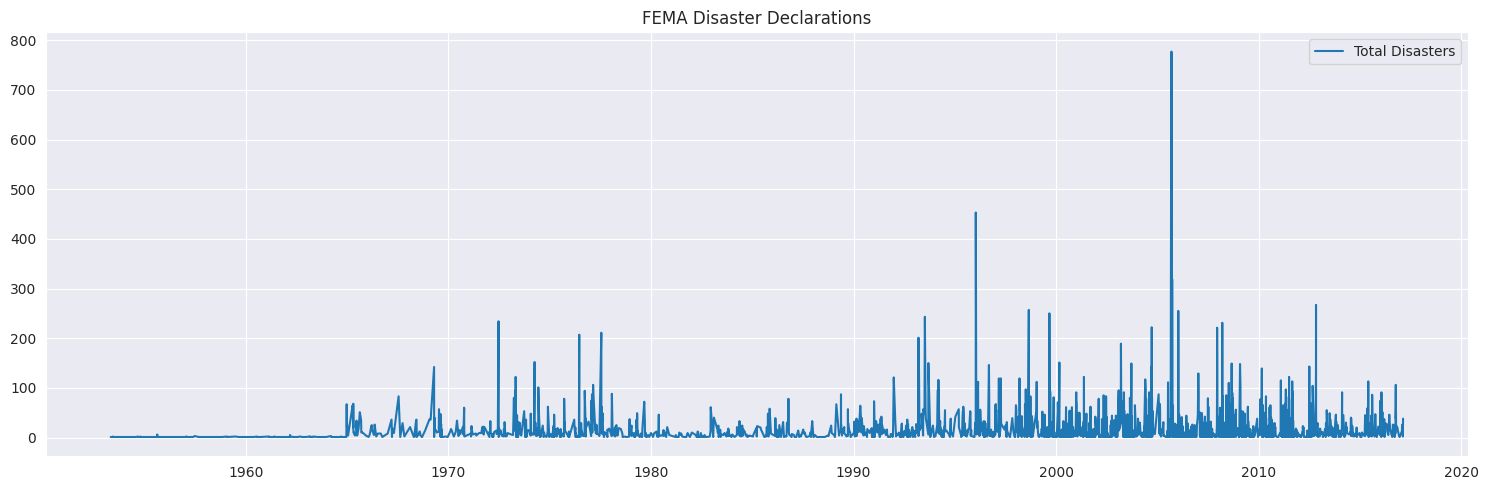

In [13]:
# Plot the time series data
plt.figure(figsize=(15, 5))
plt.plot(daily_ts_df, label='Total Disasters')
plt.title('FEMA Disaster Declarations')
plt.legend()
plt.tight_layout();

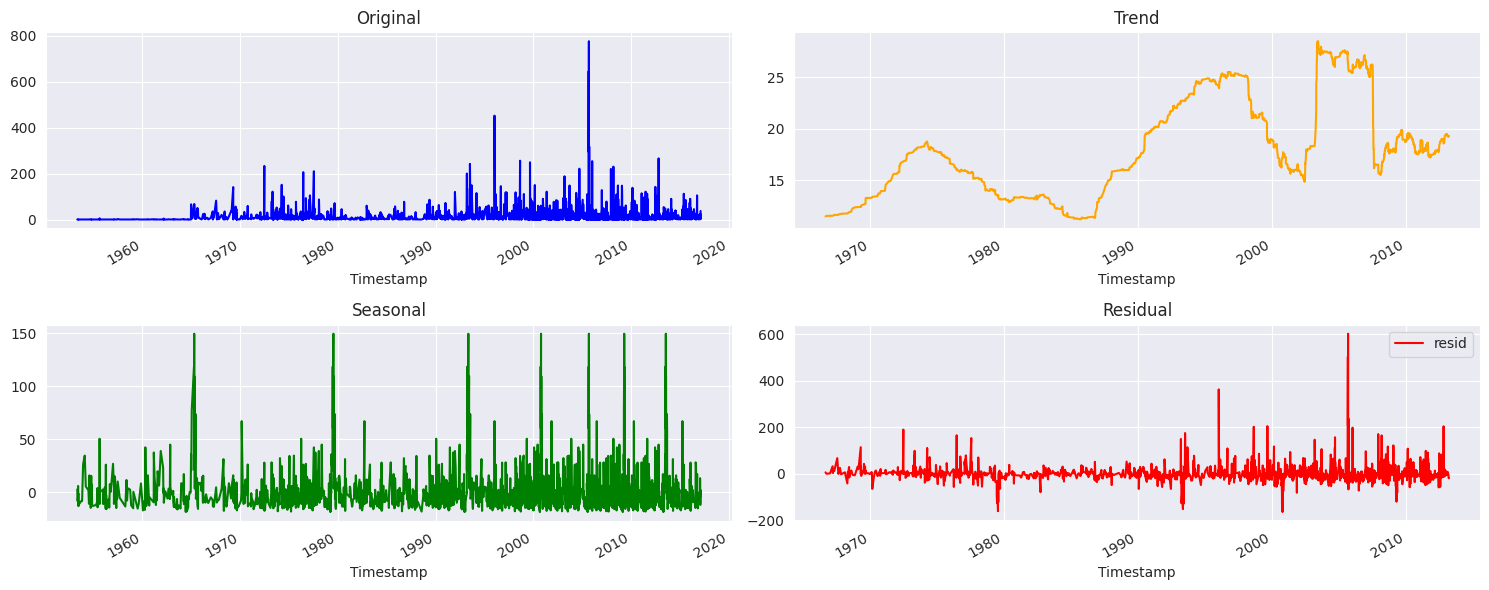

In [14]:
# Decompose
decomposition = seasonal_decompose(daily_ts_df, model='additive', period=365)


fig, axes = plt.subplots(2, 2, figsize=(15, 6))

# Plot each component in a separate subplot
decomposition.observed.plot(ax=axes[0, 0], title='Original', color='blue')
decomposition.trend.plot(ax=axes[0, 1], title='Trend', color='orange')
decomposition.seasonal.plot(ax=axes[1, 0], title='Seasonal', color='green')
decomposition.resid.plot(ax=axes[1, 1], title='Residual', color='red')

plt.legend()
plt.tight_layout();

### Stationary Check

#### Which Test Should We Choose: ADF or KPSS?

Choosing between the ADF and KPSS tests can sometimes be confusing. A practical approach is to apply both tests and cross-check their conclusions to confirm if the series is truly stationary. The following outcomes can help interpret the results:
- **Case 1:** Both tests conclude that the series is not stationary - The series is not stationary
- **Case 2:** Both tests conclude that the series is stationary - The series is stationary
- **Case 3:** KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- **Case 4:** KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.


In [15]:
# ADF Test
def adf_test(timeseries):
    print("ADF Test:\n")
    print("Null Hypothesis (H0): The series has a unit root or is non-stationary.")
    print("Alternate Hypothesis (H1): The series has no unit root or is stationary.\n")
    print("Results of Dickey-Fuller Test:\n")
    adf_result = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(
        adf_result[0:4], index=["Test Statistic", "p-value", "Lags Used", "Observations Used"]
    )
    for key, value in adf_result[4].items():
        adf_output[f"Critical Value ({key})"] = value
    print(adf_output,'\n')
    
    if adf_output.iloc[1] < 0.05:  # Use .iloc[1] for the p-value
        print("Reject H0: The series is stationary.\n")
    else:
        print("Fail to Reject H0: The series is non-stationary.\n")
        

# KPSS Test
def kpss_test(timeseries):
    print("KPSS Test:\n")
    print("Null Hypothesis (H0): The series is trend stationary or has no unit root.")
    print("Alternate Hypothesis (H1): The series has a unit root (is non-stationary).\n")
    print("Results of KPSS Test:\n")
    kpss_result = kpss(timeseries, nlags="auto")
    kpss_output = pd.Series(
        kpss_result[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpss_result[3].items():
        kpss_output[f"Critical Value ({key})"] = value
    print(kpss_output,'\n')
    
    if kpss_output.iloc[1] < 0.05:  # Use .iloc[1] for the p-value
        print("Reject H0: The series is non-stationary.\n")
    else:
        print("Fail to Reject H0: The series is stationary.\n")


In [16]:
# Check stationarity with ADF Test
adf_test(daily_ts_df) 

ADF Test:

Null Hypothesis (H0): The series has a unit root or is non-stationary.
Alternate Hypothesis (H1): The series has no unit root or is stationary.

Results of Dickey-Fuller Test:

Test Statistic         -1.603150e+01
p-value                 6.050222e-29
Lags Used               3.000000e+00
Observations Used       2.503000e+03
Critical Value (1%)    -3.432965e+00
Critical Value (5%)    -2.862695e+00
Critical Value (10%)   -2.567385e+00
dtype: float64 

Reject H0: The series is stationary.



In [17]:
# Check stationarity with KPSS Test
kpss_test(daily_ts_df)

KPSS Test:

Null Hypothesis (H0): The series is trend stationary or has no unit root.
Alternate Hypothesis (H1): The series has a unit root (is non-stationary).

Results of KPSS Test:

Test Statistic            0.384710
p-value                   0.083746
Lags Used                23.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64 

Fail to Reject H0: The series is stationary.



Obervation of the ADF and KPSS Tests:

- **Based on the ADF Test, the series is stationary** because the p-value is less than the significance level of 0.05, leading to the rejection of the null hypothesis.
- **Based on the KPSS Test, the series is stationary** because the p-value is greater than the significance level of 0.05, leading to the failure to reject the null hypothesis.
- **Conclusion: The series is stationary.**

In [18]:
def diff_inv(series_diff, first_value):
    return np.cumsum(np.insert(series_diff, 0, first_value))


# Example of original series
original_series = pd.Series([100, 102, 105, 110, 115])

# Apply differentiation
series_diff = original_series.diff().dropna()

# Invert differentiation
first_value = original_series.iloc[0]
reconstructed_series = diff_inv(series_diff, first_value)

print("Original series:", original_series.values)
print("Differentiation series", series_diff)
print("Reconstructed series:", reconstructed_series)

Original series: [100 102 105 110 115]
Differentiation series 1    2.0
2    3.0
3    5.0
4    5.0
dtype: float64
Reconstructed series: [100. 102. 105. 110. 115.]


In [19]:
# # Apply differencing to make the series stationary
# ts_data_diff = ts_data.diff().dropna()

In [20]:
# # Recheck for strict stationarity.
# adf_test(ts_data_diff)
# print('----'*20) 
# kpss_test(ts_data_diff)

#### Determining $p$ and $q$ from PACF and ACF:

- `Cuts off`: The value drops abruptly to zero.
- `Tails off`: The value gradually decays towards zero, usually in an exponential way.

- Select $p$ based on significant spikes from the PACF plot. 
    - One clue is that the ACF plot decays more slowly.
- Select $q$ from ACF if this plot has a sharp cut-off after lag $q$. 
    - One clue is that the PACF plot decays more slowly.

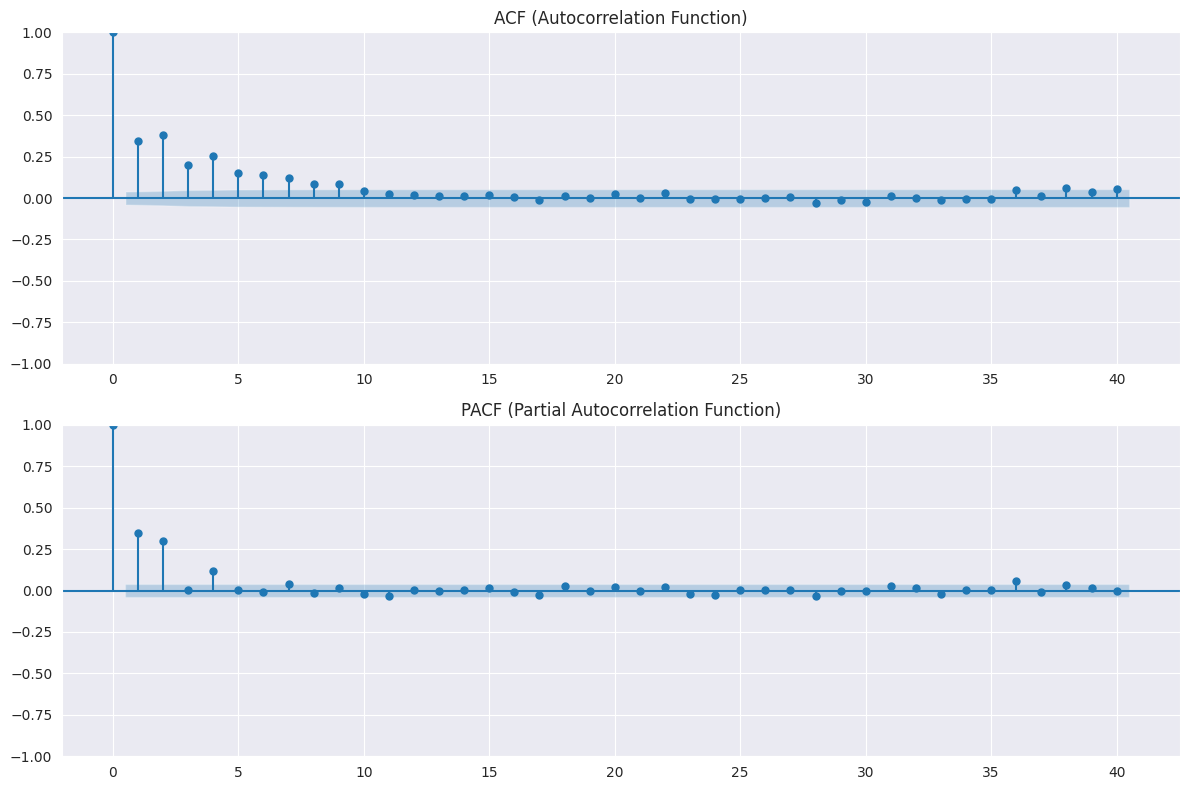

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF (Autocorrelation Function) with alpha=0.05 = 95% confidence interval
plot_acf(daily_ts_df, lags=40, alpha=0.05, ax=ax1)  
ax1.set_title('ACF (Autocorrelation Function)')

# Plot PACF (Partial Autocorrelation Function) with alpha=0.05 = 95% confidence interval
plot_pacf(daily_ts_df, lags=40, alpha=0.05, ax=ax2)  
ax2.set_title('PACF (Partial Autocorrelation Function)')

plt.tight_layout();

Dataset dimensions: (2507, 1)
Training data dimension: (2005, 1) - 79.98% of dataset
Actual data dimension: (502, 1) - 20.02% of dataset


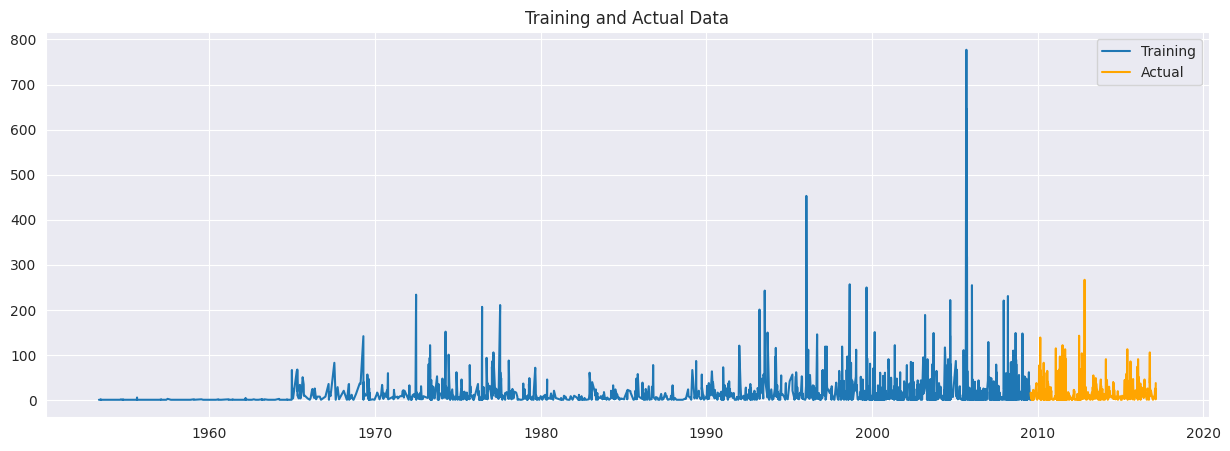

In [22]:
print('Dataset dimensions:', daily_ts_df.shape)

# Split data
train_size = int(len(daily_ts_df) * 0.8)
train_data, test_data = daily_ts_df[:train_size], daily_ts_df[train_size:]

print(f"Training data dimension: {train_data.shape} - {round((len(train_data)/len(daily_ts_df)*100), 2)}% of dataset")
print(f"Actual data dimension: {test_data.shape} - {round((len(test_data)/len(daily_ts_df)*100), 2)}% of dataset")

# Plot training & test data 
plt.figure(figsize=(15, 5))
plt.plot(train_data, label='Training')
plt.plot(test_data, label='Actual', color='orange')
plt.title("Training and Actual Data")
plt.legend();

In [69]:
# Accuracy metrics
def forecast_accuracy(actual, forecast):
    # Ensure the input arrays are numpy arrays
    actual = np.array(actual)
    forecast = np.array(forecast)
    
    # Calculate different accuracy metrics
    mape = np.mean(np.abs(actual - forecast) / np.abs(actual))  # MAPE
    me = np.mean(actual - forecast)             # ME
    mse = np.mean((actual - forecast)**2)             # MSE
    mae = np.mean(np.abs(actual - forecast))    # MAE
    mpe = np.mean((actual - forecast) / actual)   # MPE
    rmse = np.sqrt(np.mean((actual - forecast) ** 2))  # RMSE
    smape = 100 / len(actual) * np.sum((np.abs(forecast) - np.abs(actual)) / (np.abs(actual) + np.abs(forecast))) # SMAPE

    return {
        'MAPE': mape,
        'ME': me,
        'MSE': mse,
        'MAE': mae,
        'MPE': mpe,
        'RMSE': rmse,
        'SMAPE': smape
    }


# ARIMA

In [24]:
# Function to find the best p, d, q based on AIC 
def best_arima_order(time_series, p_range, d_range, q_range):
    best_aic = np.inf
    best_order = None
    best_model = None

    # Iterate over all combinations of p, d, q
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    # Fit SARIMA model
                    model = SARIMAX(time_series, order=(p, d, q))
                    model_fit = model.fit(disp=False)

                    # Check AIC
                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_order = (p, d, q)
                        best_model = model_fit
                        
                except Exception as e:
                    # Print or log the error if needed
                    print(f"Failed to fit ARIMA({p},{d},{q}): {e}")
                    continue

    return best_order, best_aic, best_model



# Set range for p, d, q
p_range = range(0, 6)  
d_range = range(0, 3)  
q_range = range(0, 6)  


# Find the best order
best_order, best_aic, best_model = best_arima_order(train_data.values, p_range, d_range, q_range)

# Output the best parameters and AIC
print(f"Best order: {best_order}")
print(f"Best AIC: {best_aic}")
print(f"Best model: {best_order}")

Best order: (3, 1, 4)
Best AIC: 20168.161977633994
Best model: (3, 1, 4)


**Rule:** The order of ARIMA should not be more than 10 summed up ($p + d + q \leq 10$)

In [25]:
arima_model = ARIMA(train_data.values, order=best_order)
arima_model_fit = arima_model.fit()

In [26]:
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2005
Model:                 ARIMA(3, 1, 4)   Log Likelihood              -10076.081
Date:                Wed, 22 Jan 2025   AIC                          20168.162
Time:                        00:31:34   BIC                          20212.985
Sample:                             0   HQIC                         20184.618
                               - 2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5150      0.140     -3.670      0.000      -0.790      -0.240
ar.L2          0.5095      0.018     28.574      0.000       0.475       0.544
ar.L3          0.4528      0.075      6.012      0.0

**Parameter Estimates:**
- **coef:** Coefficients for the model terms.
- **std err:** Standard errors of the coefficients.
- **z:** Z-statistic for testing if the coefficient is significantly different from 0.
- **P>|z|:** P-value for the z-statistic. A value less than 0.05 indicates statistical significance.
- **[0.025, 0.975]:** 95% confidence intervals for the coefficients.

**Interpreting the Coefficients:**
- **AR.L1 (Lag 1):**  Value: -0.5150 , significant (P=0.000). Suggests a negative influence of the first lag on the current value.
- **MA.L1 (Lag 1):** Value: -0.2356, not significant (P=0.093). 
- **Sigma2:** Value: 1361.2478. Represents the variance of the residuals (error term).

**Diagnostic Tests:**
- **Ljung-Box (L1) (Q):**
    - A test for autocorrelation in the residuals. A large LB value (0.03) and **Prob(Q) = 0.97 > 0.05** suggests no significant autocorrelation at lag 1.
- **Jarque-Bera (JB):**
    - A test for normality of residuals. A large JB value (258060.49), and **Prob(JB)=0.00 < 0.05** indicate that residuals are not normally distributed.
- **Heteroskedasticity (H):** Tests if residual variance is constant over time. **H=4.35** and **Prob(H)=0.00 < 0.05** suggest significant heteroskedasticity.
- **Skew:** Residuals are skewed to the right (Skew = 5.14).
- **Kurtosis:** Kurtosis of 57.63 indicates heavy tails (outliers).


In [70]:
# Forecasting
forecast_arima = arima_model_fit.forecast(steps=len(test_data))

# Get metrics
metrics_arima = forecast_accuracy(test_data.values, forecast_arima)

pd.DataFrame([metrics_arima])

,MAPE,ME,MSE,MAE,MPE,RMSE,SMAPE
0,4.879213,-2.22937,684.038505,18.000827,-4.629814,26.15413,16016.695819


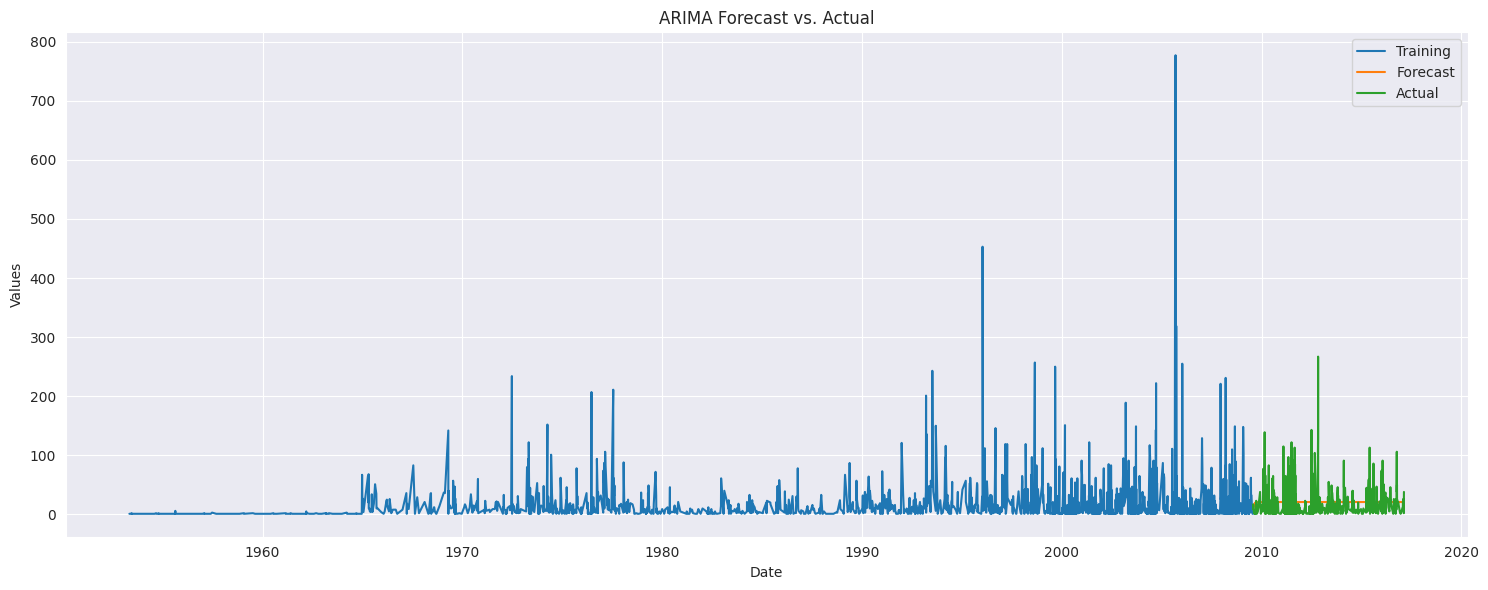

In [28]:
#  Plot the training, actual and predicted data
plt.figure(figsize=(15, 6))
plt.plot(train_data, label='Training')
plt.plot(test_data.index, forecast_arima, label='Forecast',)
plt.plot(test_data, label='Actual')
plt.title("ARIMA Forecast vs. Actual")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.tight_layout();

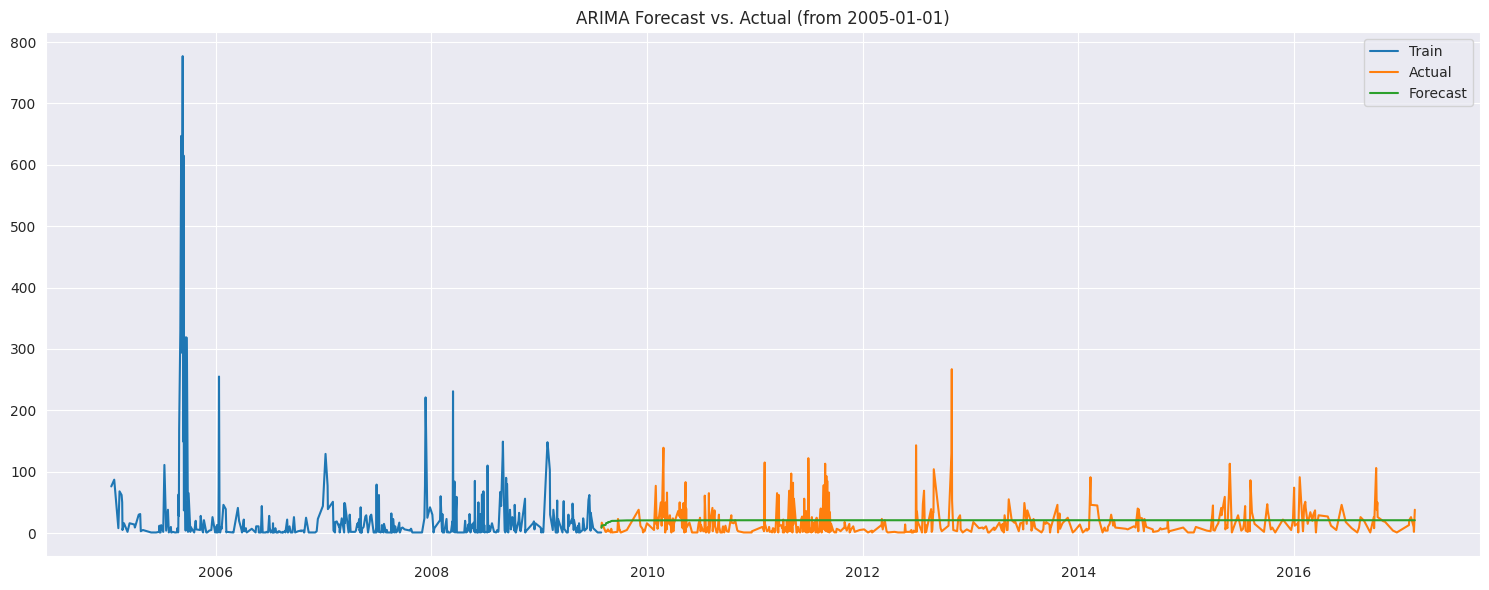

In [29]:
forecast_arima_df = pd.DataFrame(forecast_arima, index=test_data.index, columns=['Forecast'])

# Define the date range for the subset
start_date = '2005-01-01'

# Slice the data for the specified date range
train_subset1 = train_data[start_date:]
test_subset1 = test_data[start_date:]
forecast_subset1 = forecast_arima_df[start_date:]

# Plot training, test, and forecast data for the subset
plt.figure(figsize=(15, 6))
plt.plot(train_subset1, label='Train')
plt.plot(test_subset1, label='Actual')
plt.plot(forecast_subset1, label='Forecast')
plt.title(f"ARIMA Forecast vs. Actual (from {start_date})")
plt.legend()
plt.tight_layout();

# SARIMA

In [30]:
sarima_model = SARIMAX(train_data.values, order=(3,1,4), seasonal_order=(3,1,4,12))
sarima_model_fit = sarima_model.fit(disp=False)

In [31]:
print(sarima_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 2005
Model:             SARIMAX(3, 1, 4)x(3, 1, 4, 12)   Log Likelihood              -10051.782
Date:                            Wed, 22 Jan 2025   AIC                          20133.564
Time:                                    00:51:12   BIC                          20217.518
Sample:                                         0   HQIC                         20164.396
                                           - 2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8956      0.289     -3.097      0.002      -1.463      -0.329
ar.L2          0.6171      0.026   

In [71]:
# Forecasting
forecast_sarima = sarima_model_fit.forecast(steps=len(test_data))

# Get metrics
metrics_sarima = forecast_accuracy(test_data.values, forecast_sarima)

pd.DataFrame([metrics_sarima])

,MAPE,ME,MSE,MAE,MPE,RMSE,SMAPE
0,6.478289,-8.388223,762.544675,21.265857,-6.297506,27.614211,20095.792982


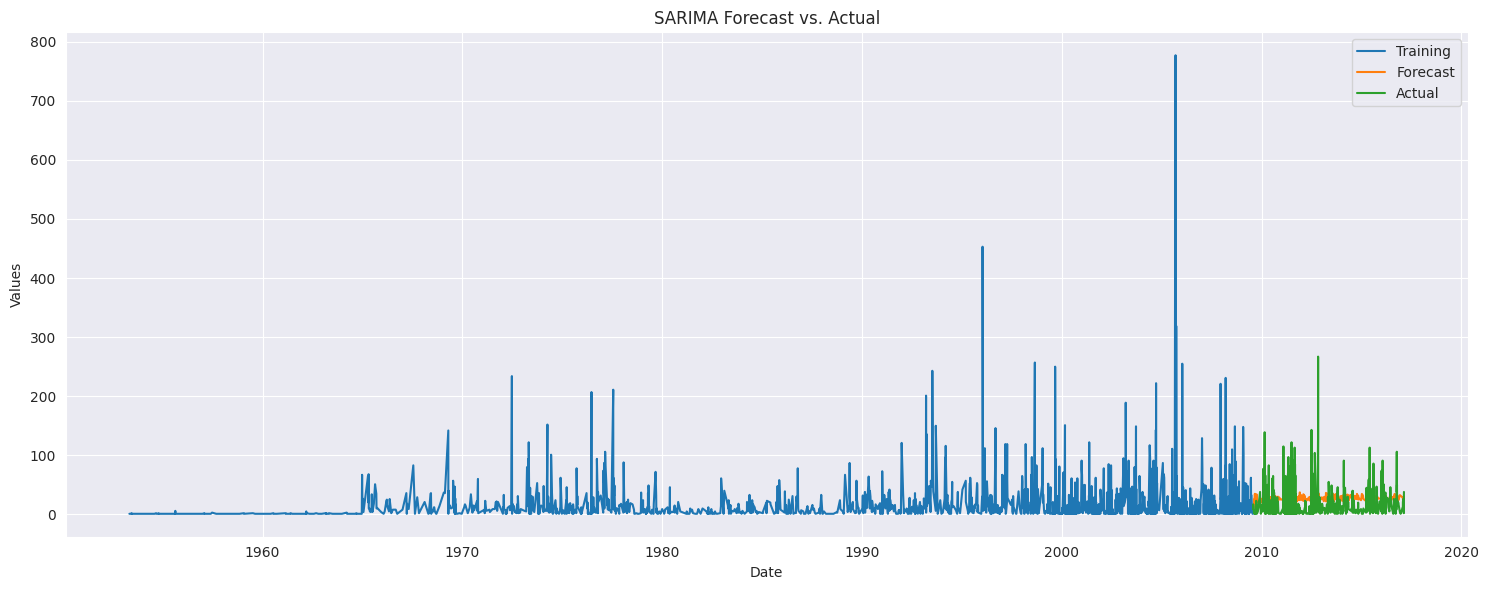

In [33]:
#  Plot the training, actual and predicted data
plt.figure(figsize=(15, 6))
plt.plot(train_data, label='Training')
plt.plot(test_data.index, forecast_sarima, label='Forecast',)
plt.plot(test_data, label='Actual')
plt.title("SARIMA Forecast vs. Actual")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.tight_layout();

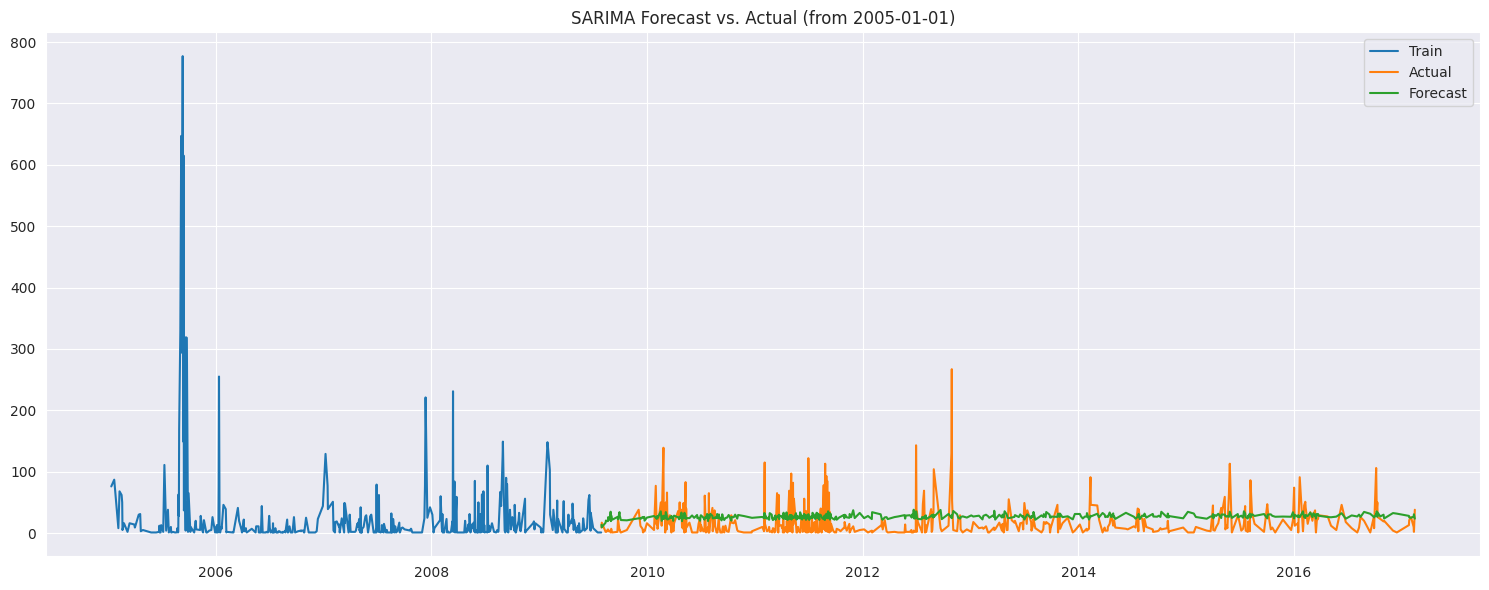

In [34]:
forecast_sarima_df = pd.DataFrame(forecast_sarima, index=test_data.index, columns=['Forecast'])

# Define the date range for the subset
start_date = '2005-01-01'

# Slice the data for the specified date range
train_subset1 = train_data[start_date:]
test_subset1 = test_data[start_date:]
forecast_subset1 = forecast_sarima_df[start_date:]

# Plot training, test, and forecast data for the subset
plt.figure(figsize=(15, 6))
plt.plot(train_subset1, label='Train')
plt.plot(test_subset1, label='Actual')
plt.plot(forecast_subset1, label='Forecast')
plt.title(f"SARIMA Forecast vs. Actual (from {start_date})")
plt.legend()
plt.tight_layout();

# Auto ARIMA

In [35]:
# Train AUto ARIMA Model 
auto_arima_model = pm.auto_arima(train_data.values, X=None, 
                                 start_p=0, d=None, start_q=0, 
                                 max_p=5, max_d=2, max_q=5, 
                                 start_P=1, D=None, start_Q=1, 
                                 max_P=2, max_D=1, max_Q=2, 
                                 max_order=5, m=12, seasonal=True, 
                                 stationary=False, information_criterion='aic', 
                                 alpha=0.05, test='adf', seasonal_test='ocsb', 
                                 stepwise=True, n_jobs=1, start_params=None, 
                                 trend=None, method='lbfgs', maxiter=300, 
                                 offset_test_args=None, seasonal_test_args=None, 
                                 suppress_warnings=True, error_action='trace', 
                                 trace=True, random=False, random_state=23, 
                                 n_fits=100, return_valid_fits=False, out_of_sample_size=0, 
                                 scoring='mse', scoring_args=None, with_intercept='auto', 
                                 sarimax_kwargs=None)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=20689.191, Time=1.20 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=20686.043, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=20410.596, Time=0.98 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=20527.082, Time=3.37 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=21034.977, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=20408.686, Time=0.14 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=20410.589, Time=0.75 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=20412.589, Time=1.95 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=20191.715, Time=0.21 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=20193.624, Time=1.44 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=20193.622, Time=1.21 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=20195.621, Time=3.05 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=20193.711, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=20193.705, Time=0.45 sec
 ARIM

In [36]:
# Print the best model found
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2005
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -10091.857
Date:                Wed, 22 Jan 2025   AIC                          20191.715
Time:                        00:51:29   BIC                          20214.128
Sample:                             0   HQIC                         20199.943
                               - 2005                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      7.9802      1.242      6.427      0.000       5.547      10.414
ar.L1          0.2445      0.007     36.566      0.000       0.231       0.258
ar.L2          0.3214      0.004     74.826      0.0

**Parameter Estimates:**
- **coef:** Coefficients for the model terms.
- **std err:** Standard errors of the coefficients.
- **z:** Z-statistic for testing if the coefficient is significantly different from 0.
- **P>|z|:** P-value for the z-statistic. A value less than 0.05 indicates statistical significance.
- **[0.025, 0.975]:** 95% confidence intervals for the coefficients.

**Interpreting the Coefficients:**
- **Intercept:** Value: 7.9802, statistically significant (P=0.000). The average level of the series when all AR components are zero.
- **AR.L1 (Lag 1):**  Value: 0.2445, significant. Suggests a positive influence of the first lag on the current value.
- **AR.L2 (Lag 2):** Value: 0.3214, significant. Indicates a strong positive influence from the second lag.
- **Sigma2:** Value: 1379.5359. Represents the variance of the residuals (error term).

**Diagnostic Tests:**
- **Ljung-Box (L1) (Q):**
    - A test for autocorrelation in the residuals. A large LB value (0.00) and **Prob(Q) = 0.99 > 0.05** suggests no significant autocorrelation at lag 1.
- **Jarque-Bera (JB):**
    - A test for normality of residuals. A large JB value (250535.43), and **Prob(JB)=0.00 < 0.05** indicate that residuals are not normally distributed.
- **Heteroskedasticity (H):** Tests if residual variance is constant over time. **H=4.35** and **Prob(H)=0.00 < 0.05** suggest significant heteroskedasticity.
- **Skew:** Residuals are skewed to the right (Skew = 5.29).
- **Kurtosis:** Kurtosis of 56.73 indicates heavy tails (outliers).


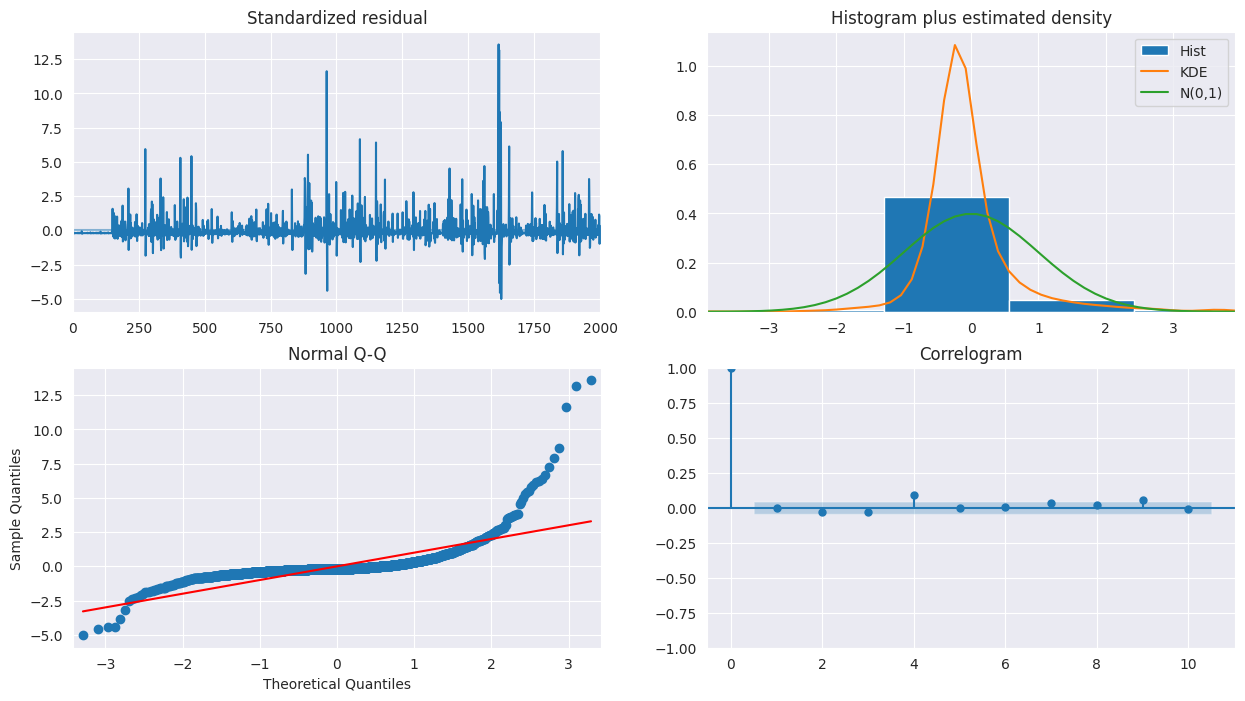

In [37]:
auto_arima_model.plot_diagnostics(figsize=(15, 8));

### Interpretation of plots in plot diagnostics

**Standardized residual:** The residual errors seem to to not fluctuate very well around a mean of zero and have a significant variance.

**Histogram:** The density plot suggest non-normal distribution.

**Theoretical Quantiles:** Mostly the dots do not fall perfectly in line with the red line. These deviations imply the distribution is skewed.

**Correlogram:** The Correlogram (or ACF plot) examines autocorrelation in the residual errors:
- Since the autocorrelation coefficients fall outside the confidence interval, the residuals are autocorrelated, indicating that the model has not effectively captured the patterns in the data.
- Therefore, additional predictors (X variables) or further model adjustments may be necessary.

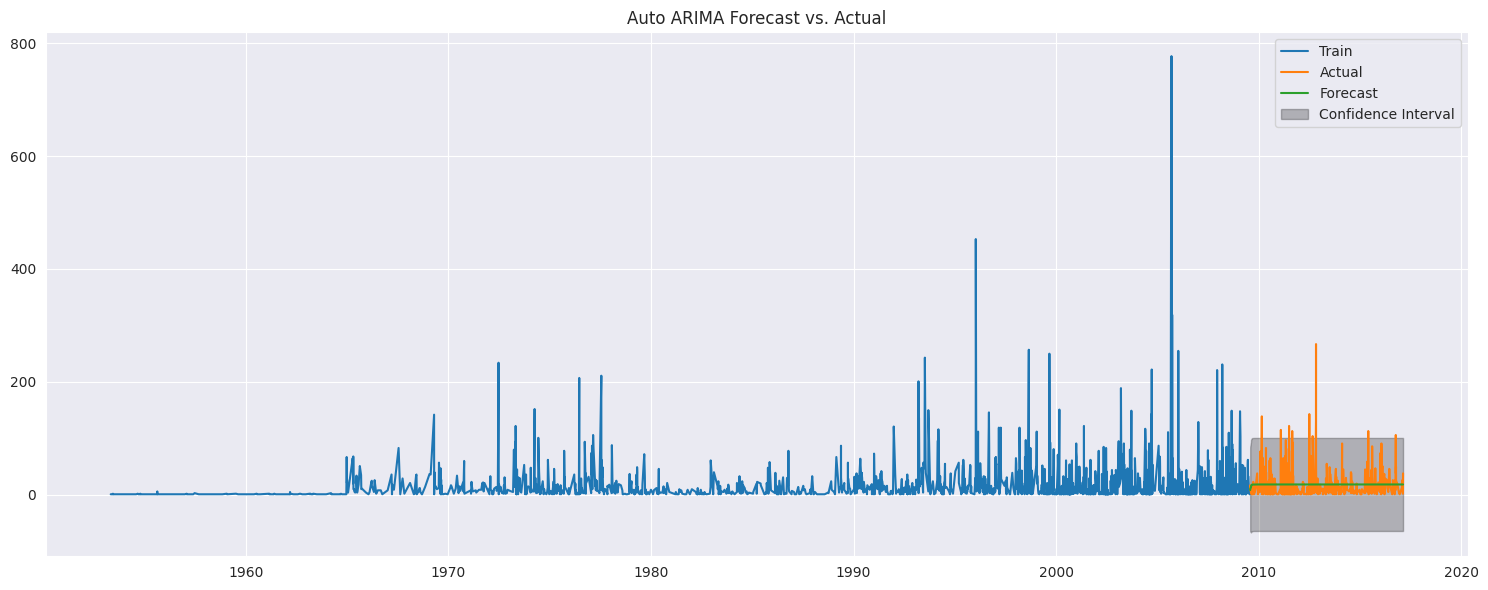

In [38]:
# Forecast
forecast_auto_arima, confint = auto_arima_model.predict(n_periods=test_data.shape[0], return_conf_int=True)

# Create a DataFrame for the forecast and confident interval
forecast_auto_arima_df = pd.DataFrame(forecast_auto_arima, index=test_data.index, columns=['Forecast'])
confint_df = pd.DataFrame(confint)

# Plot training, test, and forecast data
plt.figure(figsize=(15, 6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Actual')
plt.plot(forecast_auto_arima_df, label='Forecast')
plt.fill_between(forecast_auto_arima_df.index, 
                 confint_df[0], 
                 confint_df[1], 
                 color='k', alpha=.25, label='Confidence Interval')

plt.title("Auto ARIMA Forecast vs. Actual")
plt.legend()
plt.tight_layout();

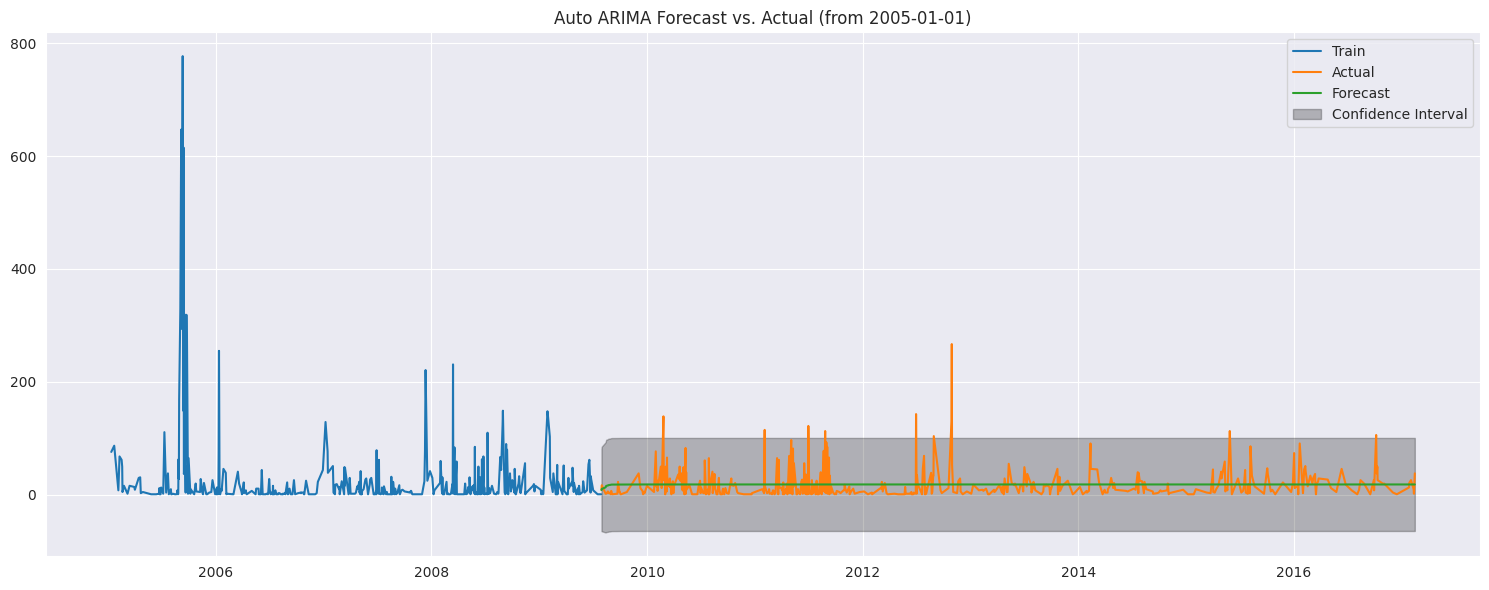

In [39]:
# Define the date range for the subset
start_date = '2005-01-01'

# Slice the data for the specified date range
train_subset = train_data[start_date:]
test_subset = test_data[start_date:]
forecast_subset = forecast_auto_arima_df[start_date:]

# Plot training, test, and forecast data for the subset
plt.figure(figsize=(15, 6))
plt.plot(train_subset, label='Train')
plt.plot(test_subset, label='Actual')
plt.plot(forecast_subset, label='Forecast')
plt.fill_between(forecast_subset.index, 
                 confint_df[0], 
                 confint_df[1], 
                 color='k', alpha=.25, label='Confidence Interval')

plt.title(f"Auto ARIMA Forecast vs. Actual (from {start_date})")
plt.legend()
plt.tight_layout();


In [72]:
###############
metrics_auto_arima = forecast_accuracy(test_data.values, forecast_auto_arima)

pd.DataFrame([metrics_auto_arima])

,MAPE,ME,MSE,MAE,MPE,RMSE,SMAPE
0,4.249967,0.249193,678.80284,17.006518,-3.958669,26.053845,13869.456994


In [41]:
""" Feature Engineering """

daily_ts_df1 = daily_ts_df.copy()
daily_ts_df1['Month'] = [daily_ts_df1.index[i].month for i in range(len(daily_ts_df1))]
daily_ts_df1.head()

,Total_Disasters,Month
Timestamp,,
1953-05-02,1.0,5
1953-05-15,1.0,5
1953-05-29,1.0,5
1953-06-02,1.0,6
1953-06-06,1.0,6


In [42]:
# Split data
train_size1 = int(len(daily_ts_df1) * 0.8)
train_data1, test_data1 = daily_ts_df1[:train_size1], daily_ts_df1[train_size1:]

In [65]:
sarima_model1 = SARIMAX(train_data1['Total_Disasters'].values, exog=train_data1['Month'].values, 
                        order=best_order, seasonal_order=(3,1,4,12))
sarima_model_fit1 = sarima_model1.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.28135D+00    |proj g|=  4.16170D-01

At iterate    5    f=  5.13916D+00    |proj g|=  9.10922D-03

At iterate   10    f=  5.12436D+00    |proj g|=  3.68122D-02

At iterate   15    f=  5.08957D+00    |proj g|=  2.04407D-02

At iterate   20    f=  5.04607D+00    |proj g|=  4.69172D-03

At iterate   25    f=  5.02018D+00    |proj g|=  5.05236D-02

At iterate   30    f=  5.01676D+00    |proj g|=  4.03344D-03

At iterate   35    f=  5.01333D+00    |proj g|=  2.01725D-03

At iterate   40    f=  5.01314D+00    |proj g|=  1.27496D-03

At iterate   45    f=  5.01303D+00    |proj g|=  1.55751D-03

At iterate   50    f=  5.01302D+00    |proj g|=  8.61339D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [73]:
# Forecasting
forecast_sarima1 = sarima_model_fit1.predict(start=len(train_data1), 
                                             end=len(train_data1) + len(test_data1) - 1,
                                             exog=test_data1['Month'].values)

# Get metrics
metrics_sarima1 = forecast_accuracy(test_data.values, forecast_sarima1)

pd.DataFrame([metrics_sarima1])

,MAPE,ME,MSE,MAE,MPE,RMSE,SMAPE
0,6.498086,-8.461332,765.699036,21.325525,-6.317302,27.671267,20112.44399


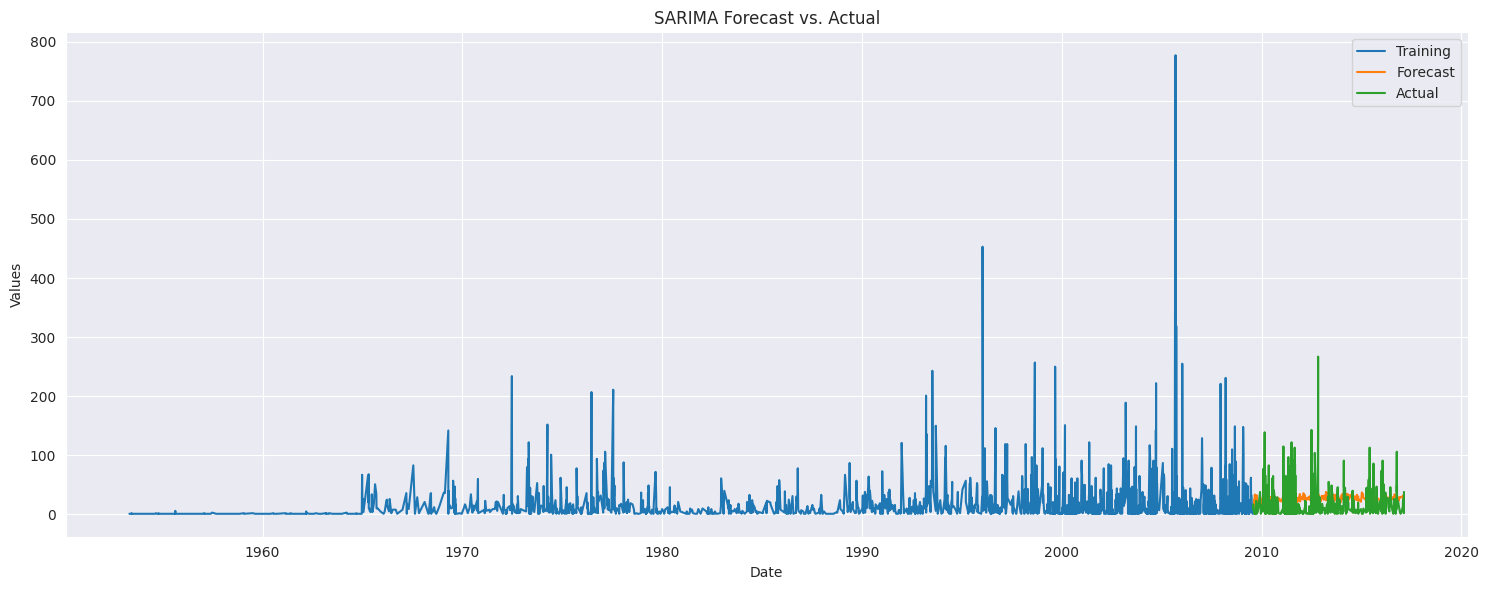

In [67]:
#  Plot the training, actual and predicted data
plt.figure(figsize=(15, 6))
plt.plot(train_data, label='Training')
plt.plot(test_data.index, forecast_sarima1, label='Forecast',)
plt.plot(test_data, label='Actual')
plt.title("SARIMA Forecast vs. Actual")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.tight_layout();


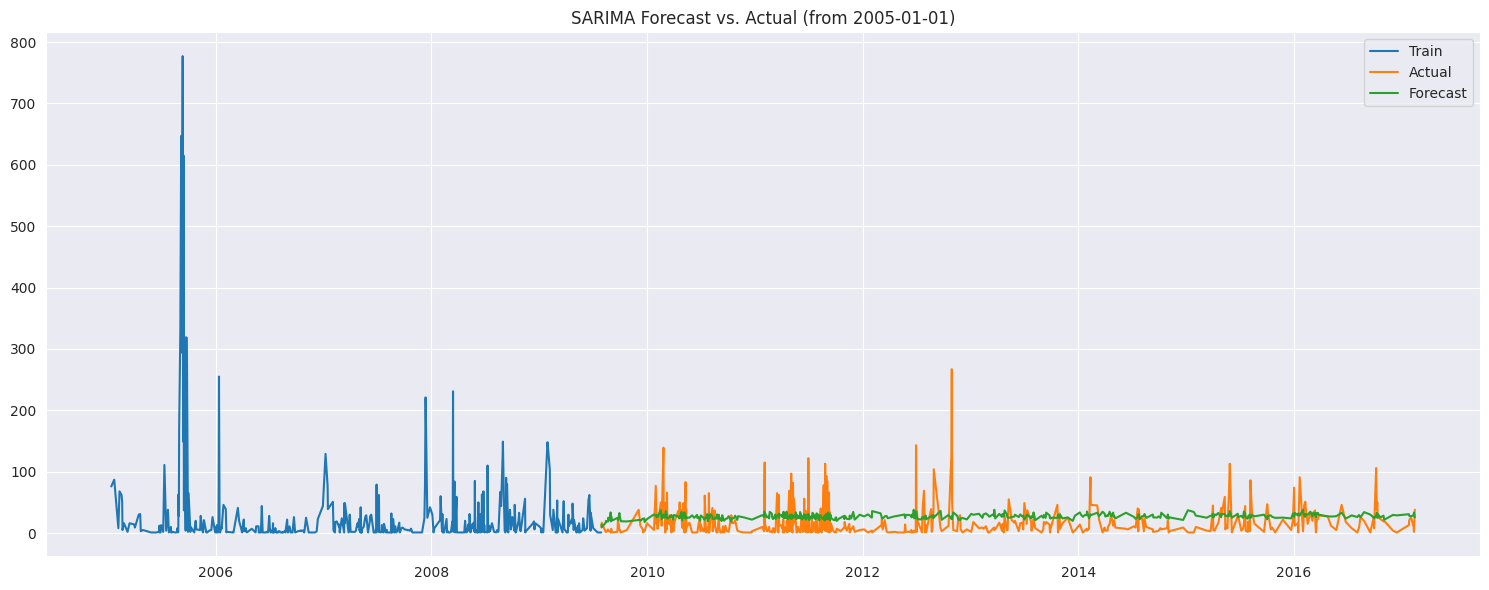

In [68]:
forecast_sarima_df1 = pd.DataFrame(forecast_sarima1, index=test_data.index, columns=['Forecast'])

# Define the date range for the subset
start_date = '2005-01-01'

# Slice the data for the specified date range
train_subset2 = train_data[start_date:]
test_subset2 = test_data[start_date:]
forecast_subset2 = forecast_sarima_df1[start_date:]

# Plot training, test, and forecast data for the subset
plt.figure(figsize=(15, 6))
plt.plot(train_subset2, label='Train')
plt.plot(test_subset2, label='Actual')
plt.plot(forecast_subset2, label='Forecast')
plt.title(f"SARIMA Forecast vs. Actual (from {start_date})")
plt.legend()
plt.tight_layout();